## Imporerer pakker

In [35]:
# Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Plotting Libraries
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Model Selection and Evaluation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import root_mean_squared_error 

# Regression Models
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.dummy import DummyRegressor

# Classification Models
from sklearn.ensemble import RandomForestClassifier

# Pipeline and Utilities
from sklearn.pipeline import Pipeline
from sklearn.tree import plot_tree

# Custom Modules
from preprocessing import prepare_data_for_death_classification, prepare_data_for_length_prediction, get_col_transformer


## Laster inn filer

In [36]:
train_df = pd.read_csv('train_df.csv')
val_df = pd.read_csv('validation_df.csv')
test_df = pd.read_csv('test_df.csv')
sample_df = pd.read_csv('sample_test.csv')

pd.set_option('display.max_columns', None)
pd.reset_option('display.float_format')

# Variabelutvinning

## Klassifikasjonsmodell for sykehusdød

In [37]:
# Forbered trenings- og valideringsdatasett for klassifikasjon
X_train_classification, numeric_cols, categorical_cols, y_train = prepare_data_for_death_classification(train_df)
X_val_classification, _, _, y_val = prepare_data_for_death_classification(val_df)
X_test_classification, _, _, y_test = prepare_data_for_death_classification(test_df)

# Oppsett av kolonnetransformasjon og klassifikasjons-pipeline
preprocessor = get_col_transformer(numeric_cols, categorical_cols, passthrough_cols=['demens'])
classification_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Tren klassifikasjonsmodellen
classification_pipeline.fit(X_train_classification, y_train)

# Valider og evaluer modellen på valideringssettet
y_val_pred = classification_pipeline.predict(X_val_classification)
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

# Evaluer modellen på testsettet
y_test_pred = classification_pipeline.predict(X_test_classification)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.2f}")


# Lagre klassifikasjonsmodellen for fremtidig bruk
with open('sykehusdod_model.pkl', 'wb') as f:
    pickle.dump(classification_pipeline, f)


Validation Accuracy: 0.85
Test Accuracy: 0.82


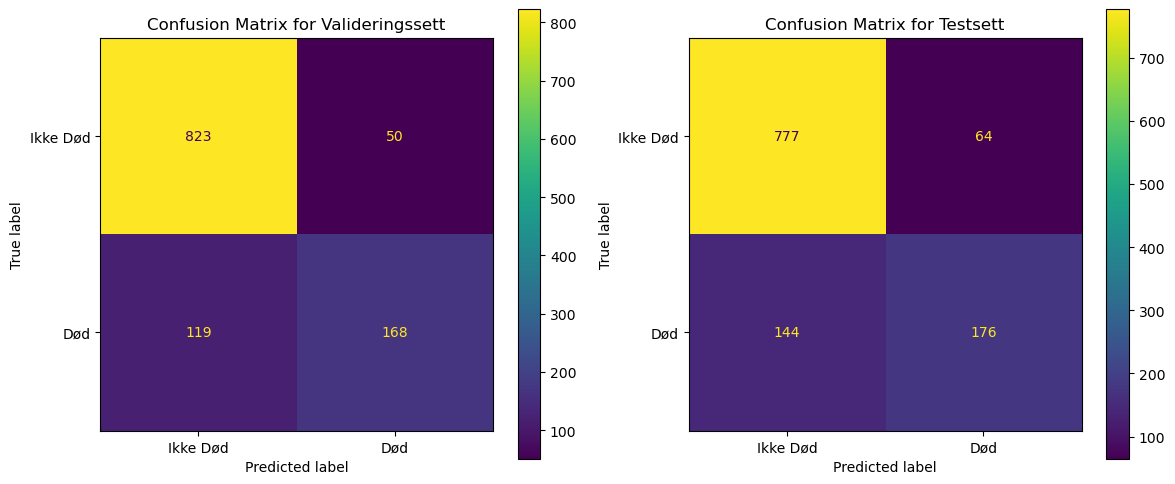

In [38]:
# Beregn confusion matrices for validerings- og testsett
conf_matrix_val = confusion_matrix(y_val, y_val_pred)
conf_matrix_test = confusion_matrix(y_test, y_test_pred)

# Opprett subplots for å vise confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Vis confusion matrix for valideringssettet i første subplot
ConfusionMatrixDisplay(conf_matrix_val, display_labels=["Ikke Død", "Død"]).plot(ax=axes[0])
axes[0].set_title("Confusion Matrix for Valideringssett")

# Vis confusion matrix for testsettet i andre subplot
ConfusionMatrixDisplay(conf_matrix_test, display_labels=["Ikke Død", "Død"]).plot(ax=axes[1])
axes[1].set_title("Confusion Matrix for Testsett")

# Juster layout og vis plottet
plt.tight_layout()
plt.show()


In [39]:
# Fjern kolonnen `sykehusdød` hvis den finnes i validerings-, test- eller utvalgsdatasett
if 'sykehusdød' in val_df.columns:
    val_df = val_df.drop(columns=['sykehusdød'])
if 'sykehusdød' in test_df.columns:
    test_df = test_df.drop(columns=['sykehusdød'])
if 'sykehusdød' in sample_df.columns:
    sample_df = sample_df.drop(columns=['sykehusdød'])

# Forbered data for klassifikasjon og prediksjon av `sykehusdød`
X_val_classification, _, _, _ = prepare_data_for_death_classification(val_df, prediction_mode=True)
X_test_classification, _, _, _ = prepare_data_for_death_classification(test_df, prediction_mode=True)
sample_classification, _, _, _ = prepare_data_for_death_classification(sample_df, prediction_mode=True)

# Imputer `sykehusdød` ved å bruke klassifikasjonsmodellen
val_df['sykehusdød'] = classification_pipeline.predict(X_val_classification)
test_df['sykehusdød'] = classification_pipeline.predict(X_test_classification)
sample_df['sykehusdød'] = classification_pipeline.predict(sample_classification)


## Oppretter nye variabler, og splitter target/features

In [40]:
# Forbered data for prediksjon av oppholdslengde
X_train, numeric_cols_train, categorical_cols_train, y_train = prepare_data_for_length_prediction(train_df, prediction_mode=False)
X_val, numeric_cols_val, categorical_cols_val, y_val = prepare_data_for_length_prediction(val_df, prediction_mode=False)
X_test, numeric_cols_test, categorical_cols_test, y_test = prepare_data_for_length_prediction(test_df, prediction_mode=False)

X_sample, numeric_cols_sample, categorical_cols_sample, y_sample = prepare_data_for_length_prediction(sample_df, prediction_mode=False)


## Imputerer manglende verdier og oneHotEncoder kategoriske variabler

In [41]:
# Vi bruker `numeric_cols_train` og `categorical_cols_train` fra funksjonen prepare_data_for_length_prediction
passthrough_cols = ['sykehusdød', 'demens', 'diabetes', 'omfattende_behandling']
col_transformer = get_col_transformer(numeric_cols_train, categorical_cols_train, passthrough_cols)

# Tren og transformer treningsdata
X_train_imputed = col_transformer.fit_transform(X_train)

# Transformer validerings- og testdata
X_val_imputed = col_transformer.transform(X_val)
X_test_imputed = col_transformer.transform(X_test)
X_sample_imputed = col_transformer.transform(X_sample)

# Få kolonnenavn uten prefikser for enklere lesbarhet
feature_names_with_prefixes = col_transformer.get_feature_names_out()
feature_names = [name.split('__')[-1] for name in feature_names_with_prefixes]

# Konverter de imputerte dataene tilbake til DataFrames med riktige kolonnenavn
X_train_imputed = pd.DataFrame(X_train_imputed, columns=feature_names)
X_val_imputed = pd.DataFrame(X_val_imputed, columns=feature_names)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=feature_names)
X_sample_imputed = pd.DataFrame(X_sample_imputed, columns=feature_names)


## Grunnlinjemodeller

In [42]:
# Opprett en baseline-modell ved hjelp av DummyRegressor med strategi 'mean'
baseline = DummyRegressor(strategy='mean')

# Tren baseline-modellen på treningsdata
baseline.fit(X_train, y_train)

# Lag prediksjoner på valideringsdata
prediction = baseline.predict(X_val)

# Beregn RMSE for baseline-modellen
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline


21.59611100410102

In [43]:
# Opprett en baseline-modell ved hjelp av DummyRegressor med strategi 'median'
baseline2 = DummyRegressor(strategy='median')

# Tren baseline-modellen på treningsdata
baseline2.fit(X_train, y_train)

# Lag prediksjoner på valideringsdata
prediction = baseline2.predict(X_val)

# Beregn RMSE for baseline-modellen ved bruk av median-strategi
rmse_baseline = root_mean_squared_error(y_val, prediction)
rmse_baseline


22.712103715253104

## Modellering

## Visualisering av actual vs predicted

In [44]:
def plot_actual_vs_pred(y_actual, y_pred, model_name):
    # Opprett en DataFrame med faktiske og predikerte verdier, samt feilen
    df = pd.DataFrame({'Actual': y_actual, 'Predicted': y_pred})
    df['Error'] = abs(df['Actual'] - df['Predicted'])  # Beregn absolutt feil (avvik mellom faktisk og predikert verdi)
    
    # Lag et spredningsdiagram med farge basert på feilens størrelse
    fig = px.scatter(
        df, x='Actual', y='Predicted', color='Error',
        color_continuous_scale='Viridis',  # Fargeskala som fremhever feilens størrelse
        title=f"{model_name}: Faktiske vs. Predikerte Verdier",
        labels={'Error': 'Prediksjonsfeil'}
    )
    
    # Legg til en diagonallinje som referanse (perfekt prediksjonslinje)
    fig.add_shape(
        type="line", x0=df['Actual'].min(), y0=df['Actual'].min(),
        x1=df['Actual'].max(), y1=df['Actual'].max(),
        line=dict(color='Red', dash='dash'),
        name="Perfekt Prediksjonslinje"
    )
    
    # Oppdater layout for klarhet
    fig.update_layout(
        xaxis_title="Faktiske Verdier",
        yaxis_title="Predikerte Verdier",
        coloraxis_colorbar=dict(title="Prediksjonsfeil"),
    )
    
    fig.show()


## RandomForestRegression

In [45]:
# Opprett en RandomForest-regresjonsmodell
model_rf = RandomForestRegressor(random_state=42)

# Tren modellen på treningsdata
model_rf.fit(X_train_imputed, y_train)

# Evaluer modellen på valideringsdata
y_val_pred_rf = model_rf.predict(X_val_imputed)
rmse_val_rf = root_mean_squared_error(y_val, y_val_pred_rf)
print(f"RMSE på Valideringssett (RandomForest): {rmse_val_rf:.3f}")

# Plot faktiske verdier mot predikerte verdier for valideringsdata
plot_actual_vs_pred(y_val, y_val_pred_rf, "RandomForestRegressor på valideringsdata - Basemodell")


RMSE på Valideringssett (RandomForest): 21.142


## ExtraTreesRegressor

In [46]:
# Definer og tren en ExtraTrees-regresjonsmodell
model_et = ExtraTreesRegressor(random_state=42)

# Tren modellen på treningsdata
model_et.fit(X_train_imputed, y_train)

# Evaluer modellen på valideringsdata
y_val_pred_et = model_et.predict(X_val_imputed)
rmse_val_et = root_mean_squared_error(y_val, y_val_pred_et)
print(f"RMSE på Valideringssett (ExtraTrees): {rmse_val_et:.3f}")

# Plot faktiske verdier mot predikerte verdier for valideringsdata
plot_actual_vs_pred(y_val, y_val_pred_et, "ExtraTreesRegressor på valideringsdata - Basemodell")


RMSE på Valideringssett (ExtraTrees): 20.733


## Ridge

In [47]:
# Definer og tren en Ridge-regresjonsmodell
model_ridge = Ridge(random_state=42)  
model_ridge.fit(X_train_imputed, y_train)

# Prediker på valideringsdata og klipp negative verdier til null
y_val_pred = model_ridge.predict(X_val_imputed)
y_val_pred = np.maximum(y_val_pred, 0)  # Setter negative prediksjoner til null
rmse_val = root_mean_squared_error(y_val, y_val_pred)
print(f"RMSE på Valideringssett (Ridge med Klipping): {rmse_val:.3f}")

# Plot faktiske verdier mot predikerte verdier for valideringsdata
plot_actual_vs_pred(y_val, y_val_pred, "Ridge (med klipping) på valideringsdata - Basemodell")


RMSE på Valideringssett (Ridge med Klipping): 20.345


## ExtraTreesRegressor med log transformasjon av target variabel

In [48]:
# Log-transformasjon av y_train
y_train_log = np.log1p(y_train)

# Opprett subplott-figur med to kolonner
fig = make_subplots(rows=1, cols=2, subplot_titles=("Opprinnelig y_train", "Log-transformert y_train"))

# Legg til histogram av opprinnelig y_train i første subplott
fig.add_trace(
    go.Histogram(x=y_train, name="Opprinnelig y_train"),
    row=1, col=1)

# Legg til histogram av log-transformert y_train i andre subplott
fig.add_trace(
    go.Histogram(x=y_train_log, name="Log-transformert y_train"),
    row=1, col=2)

# Oppdater layout for bedre visualisering
fig.update_layout(title_text="Sammenligning av Opprinnelig og Log-transformert y_train", showlegend=False)

# Vis subplottene
fig.show()


In [49]:
# Log-transformer målvariabelen
y_train_log = np.log1p(y_train)  # log1p anvender log(1 + y) for å unngå problemer med log(0)

# Definer og tren ExtraTrees-modellen på log-transformert målvariabel
model_et = ExtraTreesRegressor(random_state=42)
model_et.fit(X_train_imputed, y_train_log)

# Evaluer på valideringsdata ved å predikere og anvende den inverse log-transformasjonen
y_val_pred_log = model_et.predict(X_val_imputed)
y_val_pred_et = np.expm1(y_val_pred_log)  # Bruk expm1 for å reversere log1p-transformasjonen

# Beregn RMSE på den opprinnelige skalaen
rmse_val_et = root_mean_squared_error(y_val, y_val_pred_et)
print(f"RMSE på Valideringssett (ExtraTrees med Log-transformasjon): {rmse_val_et:.3f}")
plot_actual_vs_pred(y_val, y_val_pred_et, "Ridge (med klipping) på valideringsdata - Basemodell")


RMSE på Valideringssett (ExtraTrees med Log-transformasjon): 20.763


## Variabler brukt for å finne beste parametere på valideringsdata for GridSearchCV og RandomizedSearchCV

In [50]:
# Kombiner målvariabelen fra trenings- og valideringssett
y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=True)

# Kombiner funksjonssettet fra trenings- og valideringsdata
X_combined = pd.concat([X_train_imputed, X_val_imputed], axis=0).reset_index(drop=True)

# Opprett en PredefinedSplit som markerer hvilke data som er trening og hvilke som er validering
split_index = [-1] * len(X_train_imputed) + [0] * len(X_val_imputed)
pds = PredefinedSplit(test_fold=split_index)

## Finner best Alpha for Ridge

In [51]:
# Definer parameterområdet for alpha
param_grid = {'alpha': np.logspace(-3, 3, 10)}  # Område fra 0.001 til 1000

# Sett opp GridSearchCV med Ridge-modellen
ridge_cv = GridSearchCV(
    estimator=Ridge(random_state=42),
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=pds,  # Bruker PredefinedSplit til å evaluere kun på valideringsdata
    n_jobs=-1  # Bruker alle tilgjengelige prosessorkjerner
)

# Kjør GridSearchCV på kombinerte trenings- og valideringsdata
ridge_cv.fit(X_combined, y_combined)

# Hent beste alpha og tilhørende RMSE-score på valideringssettet
best_alpha = ridge_cv.best_params_['alpha']
best_rmse = -ridge_cv.best_score_  # Konverter til positiv verdi for RMSE
print(f"Beste Alpha: {best_alpha}")
print(f"Beste RMSE på Valideringssett: {best_rmse:.3f}")

# Tren en Ridge-modell med beste alpha kun på treningsdata
best_ridge_model = Ridge(alpha=best_alpha, random_state=42)
best_ridge_model.fit(X_train_imputed, y_train)

# Prediker og klipp negative verdier til null for valideringsprediksjoner
y_val_pred_best = best_ridge_model.predict(X_val_imputed)
y_val_pred_best = np.maximum(y_val_pred_best, 0)  # Setter negative verdier til null
rmse_val_best = root_mean_squared_error(y_val, y_val_pred_best)
print(f"Optimalisert RMSE på Valideringssett med Klipping: {rmse_val_best:.3f}")


Beste Alpha: 46.41588833612773
Beste RMSE på Valideringssett: 20.361
Optimalisert RMSE på Valideringssett med Klipping: 20.348


## Hyperparamtertuning av ExtraTreesRegressor med log transformert target variabel

In [52]:
# Log-transformer målvariabelen for å redusere skjevhet
y_train_log = np.log1p(y_train)

# Definer parameterområdet for ExtraTreesRegressor
param_grid_et = {
    'n_estimators': [100, 200, 500],         # Antall trær i ensemblet
    'max_depth': [10, 20, 50, None],         # Maks dybde for hvert tre
    'min_samples_split': [2, 5, 10],         # Minste antall prøver for å splitte en node
    'min_samples_leaf': [1, 2, 4],           # Minste antall prøver for å danne et blad
    'bootstrap': [True, False]               # Om bootstrap-prøver skal brukes for å bygge trærne
}

# Initialiser RandomizedSearchCV for ExtraTreesRegressor med forhåndsdefinert deling
random_search_et = RandomizedSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_distributions=param_grid_et,
    n_iter=50,  # Antall parameterkombinasjoner å teste
    cv=pds,  # Forhåndsdefinert deling for trenings- og valideringsdata
    scoring='neg_root_mean_squared_error',  # Bruker negativ RMSE for skåring
    verbose=2,
    random_state=42,
    n_jobs=-1  # Bruker alle tilgjengelige kjerner
)

# Tren RandomizedSearchCV på det kombinerte datasettet med log-transformert målvariabel
random_search_et.fit(X_combined, np.log1p(y_combined))

# Hent beste hyperparametere og RMSE på log-skala
best_params_et = random_search_et.best_params_
best_rmse_log = -random_search_et.best_score_  # Konverter til positiv for RMSE
print(f"Beste Hyperparametere: {best_params_et}")
print(f"Beste RMSE på Log-skala: {best_rmse_log:.3f}")

# Omregn beste RMSE til opprinnelig skala (tilnærming)
best_rmse_original_scale = np.expm1(best_rmse_log)
print(f"Omtrentlig Beste RMSE på Opprinnelig Skala: {best_rmse_original_scale:.3f}")

# Tren ExtraTreesRegressor med beste parametere på kun log-transformerte treningsdata
best_et_model = ExtraTreesRegressor(**best_params_et, random_state=42)
best_et_model.fit(X_train_imputed, y_train_log)

# Prediker på valideringssettet (log-skala)
y_val_pred_log = best_et_model.predict(X_val_imputed)

# Inverter log-transformasjonen for prediksjoner på valideringsdata
y_val_pred_et = np.expm1(y_val_pred_log)

# Beregn RMSE for prediksjoner på opprinnelig skala
rmse_val_et = root_mean_squared_error(y_val, y_val_pred_et)
print(f"RMSE på Valideringssett med Log-transformasjon Anvendt: {rmse_val_et:.3f}")

# Visualiser faktiske vs predikerte verdier
plot_actual_vs_pred(y_val, y_val_pred_et, "Beste ExtraTreesRegressor med Log-transformasjon på valideringsdata")


Fitting 1 folds for each of 50 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   3.1s
[CV] END bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   4.8s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   6.9s
[CV] END bootstrap=False, max_depth=50, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   7.7s
[CV] END bootstrap=False, max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   9.0s
[CV] END bootstrap=True, max_depth=50, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   9.3s
[CV] END bootstrap=False, max_depth=20, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   9.5s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time

## Hyperparametertuning ExtraTreesRegressor RandomizedSearchCV

In [53]:
# Definer parameterområdet for RandomizedSearchCV med ExtraTreesRegressor
param_grid_et = {
    'n_estimators': [100, 200, 300, 500, 700],  # Mer detaljert kontroll for antall trær
    'max_depth': [10, 20, 30, 50, None],        # Flere alternativer for å kontrollere overtilpasning
    'min_samples_split': [2, 5, 10, 15],        # Økt verdi for færre splits
    'min_samples_leaf': [1, 2, 4, 8],           # Større minsteløvsstørrelser for å redusere overtilpasning
    'bootstrap': [True],                        # Bootstrapping for varianskontroll
    
    # Ekstra parametere
    'max_features': ['sqrt', 'log2', 0.5, 1],   # Kontroll over antall funksjoner per split
    'min_impurity_decrease': [0.0, 0.01, 0.05], # Grense for å redusere antall splits
    'max_samples': [None, 0.8, 0.9]             # Andel av prøver brukt for hvert tre
}

# Initialiser RandomizedSearchCV for ExtraTreesRegressor
random_search_et = RandomizedSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_distributions=param_grid_et,
    n_iter=50,
    cv=pds,  # Bruker PredefinedSplit for å holde valideringsdata separat
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=42,
    n_jobs=-1  # Bruk alle tilgjengelige kjerner
)

# Kjør RandomizedSearchCV på kombinerte trenings- og valideringsdata
random_search_et.fit(X_combined, y_combined)

# Hent beste hyperparametere og RMSE-score
best_params_et = random_search_et.best_params_
best_rmse_et = -random_search_et.best_score_  # Konverter til positiv RMSE
print(f"Beste Hyperparametere: {best_params_et}")
print(f"Beste RMSE på Valideringssett: {best_rmse_et:.3f}")

# Tren ExtraTreesRegressor med de beste parametrene kun på treningsdata
best_et_model = ExtraTreesRegressor(**best_params_et, random_state=42)
best_et_model.fit(X_train_imputed, y_train)

# Prediker på valideringsdata
y_val_pred_best_et = best_et_model.predict(X_val_imputed)

# Beregn RMSE for prediksjoner på valideringssettet
rmse_val_best_et = root_mean_squared_error(y_val, y_val_pred_best_et)
print(f"Optimalisert RMSE på Valideringssett: {rmse_val_best_et:.3f}")

# Visualiser faktiske vs predikerte verdier hvis plot-funksjonen er definert
plot_actual_vs_pred(y_val, y_val_pred_best_et, "Beste ExtraTreesRegressor på Valideringsdata (RandomizedSearch)")


Fitting 1 folds for each of 50 candidates, totalling 50 fits
[CV] END bootstrap=True, max_depth=20, max_features=1, max_samples=0.8, min_impurity_decrease=0.01, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=10, max_features=log2, max_samples=None, min_impurity_decrease=0.01, min_samples_leaf=8, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END bootstrap=True, max_depth=20, max_features=1, max_samples=None, min_impurity_decrease=0.01, min_samples_leaf=8, min_samples_split=10, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, max_samples=0.9, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, max_samples=0.8, min_impurity_decrease=0.05, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   1.5s
[CV] END bootstrap=True, max_depth=30

## Hyperparamtertuning for ExtraTreesRegressor med GridSearch i smalere intervall

In [54]:
# Bruk de beste parameterne som midtpunkt i et finjustert grid
param_grid_et_refined = {
    'n_estimators': [90, 100, 110],                  # Smalere område nær 100 for mer presis tuning
    'max_depth': [25, 30, 35],                       # Fokus rundt 30 for maks dybde
    'min_samples_split': [4, 5, 6],                  # Sentrert rundt 5 med færre valg
    'min_samples_leaf': [1, 2, 3],                   # Tett område rundt 2
    'min_impurity_decrease': [0.0, 0.001, 0.002],    # Finere justering rundt 0.0
    'max_samples': [0.8, 0.9],                       # Begrenset til 80-90% sample bruk
    'max_features': ['sqrt', 0.3, 0.4],              # Verdiområdet nær sqrt og 0.4
    'bootstrap': [True]                              # Fastsatt til True basert på tidligere resultater
}


# Initialiser GridSearchCV for ExtraTreesRegressor
grid_search_et = GridSearchCV(
    estimator=ExtraTreesRegressor(random_state=42),
    param_grid=param_grid_et_refined,
    cv=pds,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1
)

# Kjør GridSearchCV på de kombinerte trenings- og valideringsdataene
grid_search_et.fit(X_combined, y_combined)

# Hent beste hyperparametere fra GridSearch
best_params_grid = grid_search_et.best_params_
print(f"Beste Hyperparametere fra GridSearch: {best_params_grid}")

# Beste RMSE-score fra GridSearch
best_rmse_grid = -grid_search_et.best_score_  # Konverter til positiv RMSE
print(f"Beste RMSE-score fra GridSearch: {best_rmse_grid:.3f}")

# Tren ExtraTreesRegressor med de beste parametrene kun på treningsdata
best_et_model_grid = ExtraTreesRegressor(**best_params_grid, random_state=42)
best_et_model_grid.fit(X_train_imputed, y_train)

# Prediker på valideringssettet
y_val_pred_best_et_grid = best_et_model_grid.predict(X_val_imputed)

# Beregn RMSE for prediksjoner på valideringssettet
rmse_best_et_grid = root_mean_squared_error(y_val, y_val_pred_best_et_grid)
print(f"RMSE på Valideringssett med Full Funksjonalitet (GridSearch): {rmse_best_et_grid:.3f}")

# Visualiser faktiske vs predikerte verdier
plot_actual_vs_pred(y_val, y_val_pred_best_et_grid, "Best ExtraTreesRegressor på valideringsdata (GridSearch)")


Fitting 1 folds for each of 1458 candidates, totalling 1458 fits
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, max_samples=0.8, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=6, n_estimators=90; total time=   1.6s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, max_samples=0.8, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=5, n_estimators=90; total time=   1.7s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, max_samples=0.8, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=6, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, max_samples=0.8, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, n_estimators=90; total time=   1.8s
[CV] END bootstrap=True, max_depth=25, max_features=sqrt, max_samples=0.8, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=25,

## Laster ned beste modell

In [55]:
with open('model.pkl', 'wb') as f:
    pickle.dump((best_et_model_grid, col_transformer, feature_names), f)

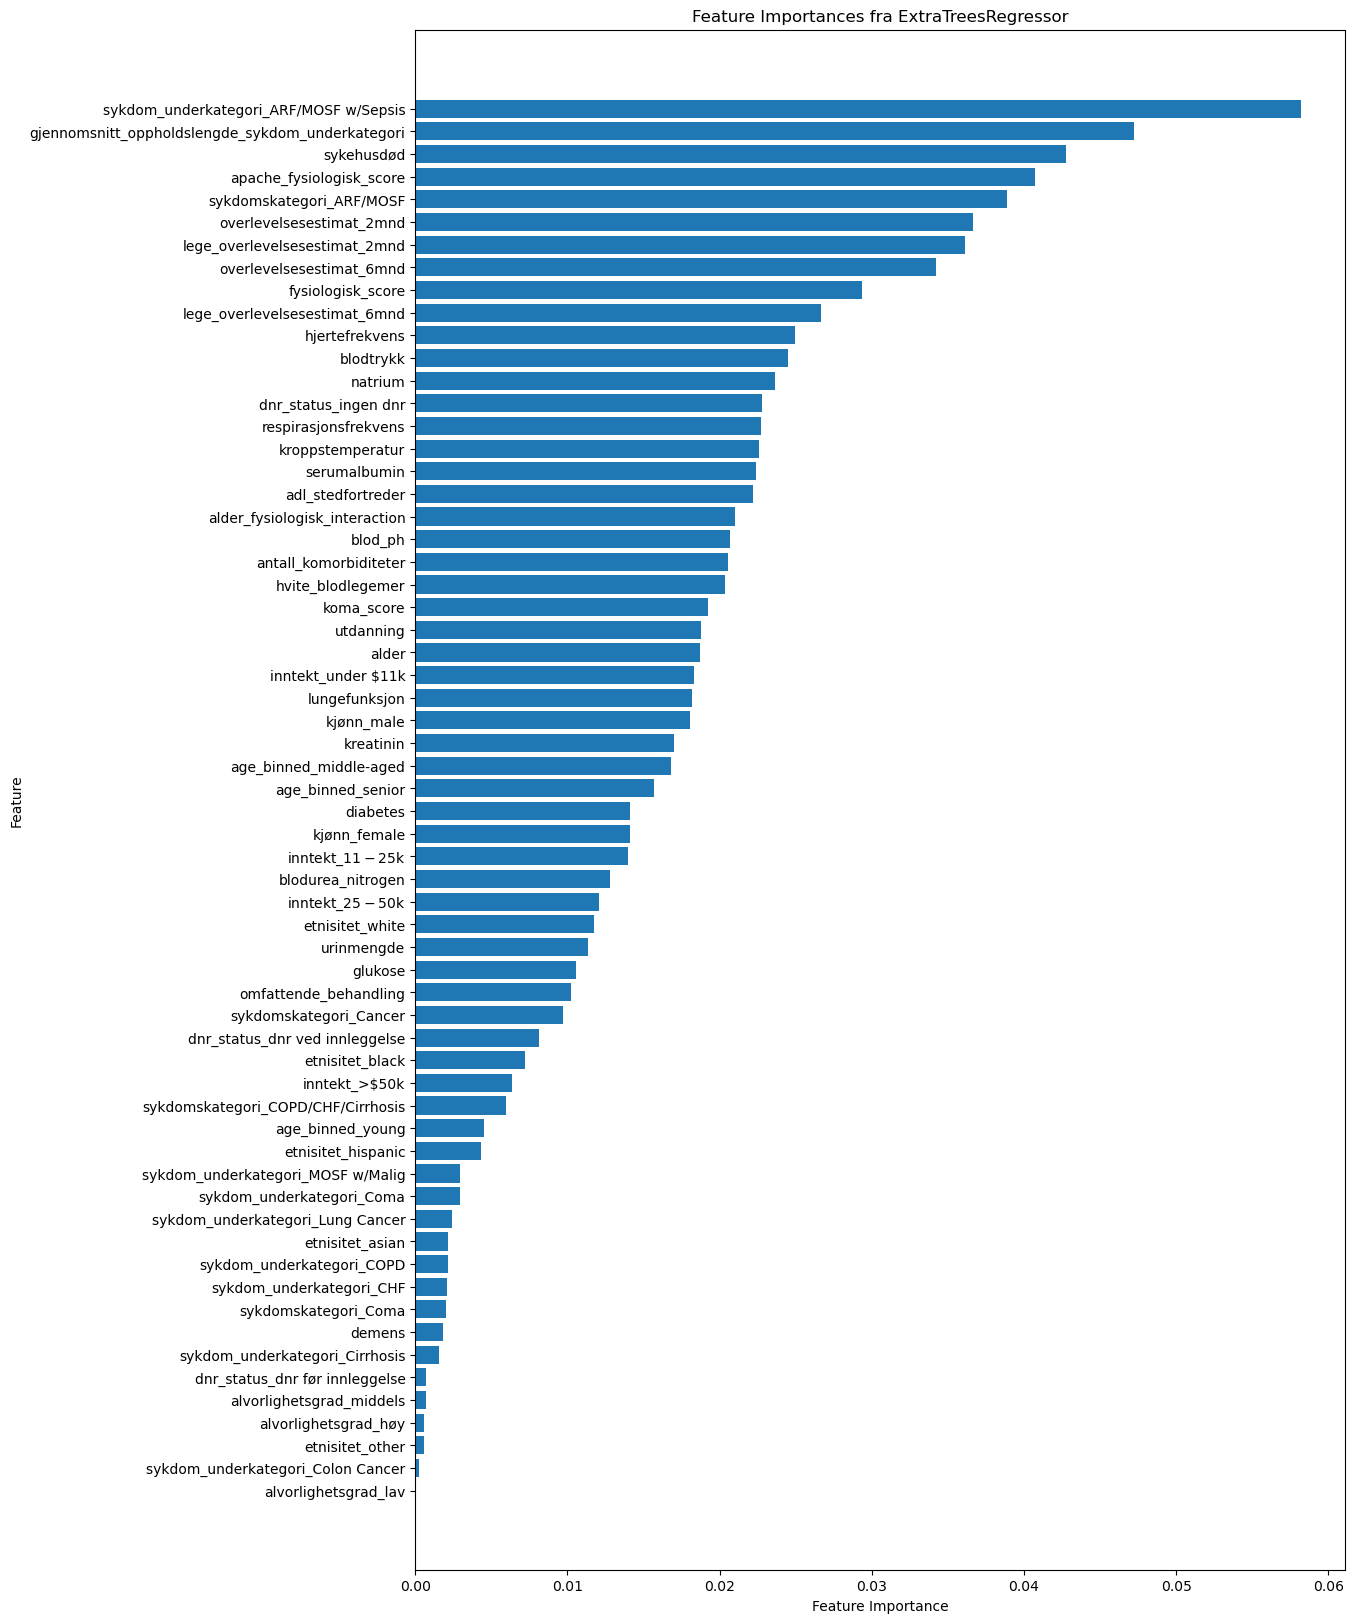

In [56]:
# Hent feature importances fra den beste modellen
importances = best_et_model_grid.feature_importances_

# Kombiner variabelnavn og deres betydning (importances) i en DataFrame
feature_importances = pd.DataFrame({'Funksjon': feature_names, 'Betydning': importances})

# Sorter funksjonene etter deres betydning i synkende rekkefølge
feature_importances = feature_importances.sort_values('Betydning', ascending=False)

# Visualiser feature importances for en bedre forståelse av betydningene
plt.figure(figsize=(12, 20))  
plt.barh(feature_importances['Funksjon'], feature_importances['Betydning'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importances fra ExtraTreesRegressor')
plt.gca().invert_yaxis()  # Inverter y-aksen slik at den viktigste funksjonen vises øverst
plt.show()


## Tester beste modellen på test-data

In [57]:
# Prediker verdier på testdata ved bruk av den beste modellen
y_test_pred = best_et_model_grid.predict(X_test_imputed)

# Beregn RMSE på testdataene for å evaluere modellens ytelse
rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"RMSE på Testsettet: {rmse:.3f}")

# Visualiser faktiske vs. predikerte verdier for testdataene
plot_actual_vs_pred(y_test, y_test_pred, "Best ExtraTreesRegressor på testdata")


RMSE på Testsettet: 21.456


## Predikerer sample data med beste modell

In [58]:
# Predikerer verdier på sampledata ved bruk av den beste modellen
y_sample_pred = best_et_model_grid.predict(X_sample_imputed)

# Visualiser fordelingen av predikerte verdier på sampledata
fig = px.histogram(y_sample_pred, title="Fordeling av Prediksjoner på Sample Data")
fig.update_xaxes(title="Predikerte Verdier")
fig.update_yaxes(title="Antall")
fig.show()

In [67]:
prediksjon_sample = pd.DataFrame(sample_df['pasient_id'])
prediksjon_sample['estimert_oppholdslengde'] = y_sample_pred
prediksjon_sample['estimert_oppholdslengde'] = prediksjon_sample['estimert_oppholdslengde'].round(0).astype(int)
prediksjon_sample.to_csv('predictions.csv', index=False)
prediksjon_sample


,pasient_id,estimert_oppholdslengde
0,2,11
1,3,13
2,4,8
3,5,26
4,6,11
...,...,...
7735,9101,19
7736,9102,34
7737,9103,15
7738,9104,14
